# Init

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
#help(env) #this will explain the env

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


# Easy strategy (Task1.1)
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        if state[0] > 17:
            action = 0 # stop
        else:
            action = 1 # hit +1 card
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [ ]:
for i in range(5):
    episode = generate_episode_from_limit_stochastic(env)
    states, actions, rewards = zip(*episode)
    print(rewards[-1])
    print(episode)

1.0
[((10, 4, False), 1, 0.0), ((15, 4, False), 1, 0.0), ((18, 4, False), 0, 1.0)]
1.0
[((15, 7, False), 1, 0.0), ((19, 7, False), 0, 1.0)]
-1.0
[((15, 10, False), 1, -1.0)]
0.0
[((12, 10, False), 1, 0.0), ((18, 10, False), 0, 0.0)]
-1.0
[((16, 2, False), 1, -1.0)]


## Monte Carlo methods

Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


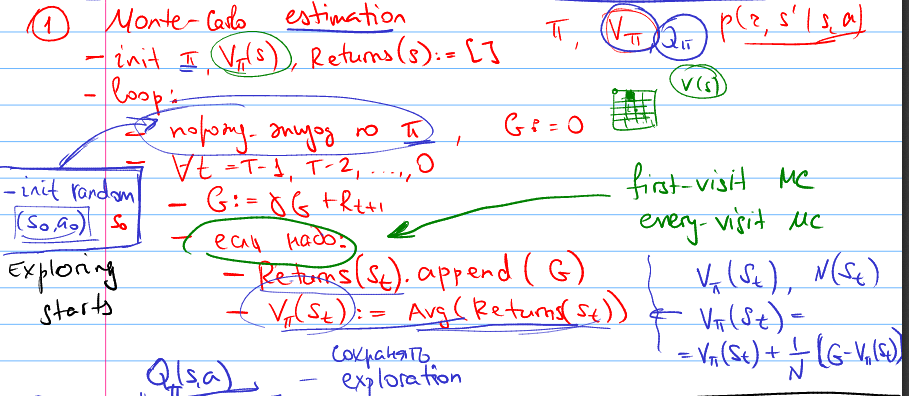

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma = 0.8):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    rewards_list = []
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            
        # generate an episode
        episode = generate_episode(env)
        # print('\n Episode: \n')
        # print(episode)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # print('\n actions: \n')
        # print(actions)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) 
        rewards_list.append(rewards[-1])

        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states): #ever-visit
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)]) #sum(rewards[i:]) # смотрим с конца
            # Avg(Returns)
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        # print('\n Returns(S, A): \n')
        # print(returns_sum)
        
        # print('\n Q: \n')
        # print(Q)

    return Q, rewards_list

Для каждого состояния (сумма игрока, открытая карта диллера, наличие ace) имеем усредненное значение награды для обоих действий (stand, hit)

In [ ]:
Q, rew = mc_prediction_q(env, 10_000, generate_episode_from_limit_stochastic)

Episode 10000/10000.

Выигрыш стратегии

In [ ]:
sum(rew) / 10_000

-0.123

# Monte Carlo Control (Task 1.2-3)

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Нарисуйте графики среднего дохода вашего метода

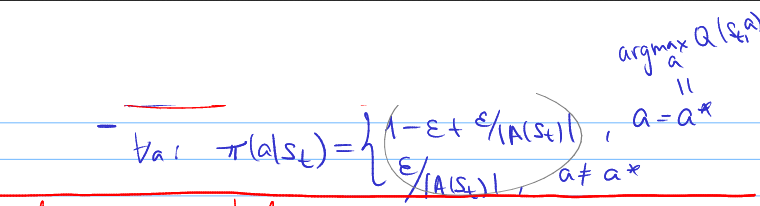

In [5]:
# Epsilon-мягкая
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # a <> a*
    policy_s = np.ones(nA) * epsilon / nA # array из nA элементов (в нашем случае из 2х)
    # a == a*
    a_star = np.argmax(Q_s)
    policy_s[a_star] = 1 - epsilon + (epsilon / nA)
    return policy_s

Аналогично прошлому, только со стратегией случайного выбора с вер-ми

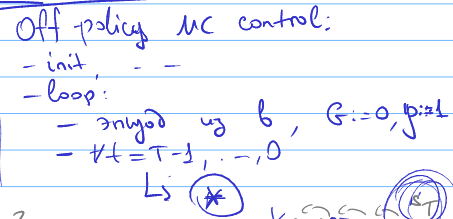

In [6]:
def generate_episode_from_Q(bj_env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = bj_env.reset()
    while True:
        if state in Q:
            probas = get_probs(Q[state], epsilon, nA)
            # print("\n probas: \n")
            # print(probas)
            # выбор одного из nA случайных действий (в нашем случае из 2х)
            action = np.random.choice(np.arange(nA), p=probas)
        else:
            action = bj_env.action_space.sample() #random init
          
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [7]:
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA))
eps=.9


for i in range(5):
    print(generate_episode_from_Q(env, Q, eps, nA))

[((20, 10, False), 0, 1.0)]
[((20, 10, False), 1, -1.0)]
[((7, 5, False), 0, 1.0)]
[((20, 10, False), 1, -1.0)]
[((8, 10, False), 0, -1.0)]


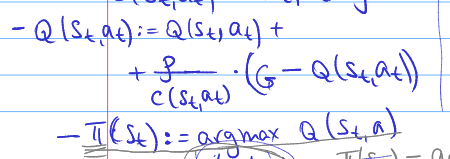

In [8]:
def average_reward(env, Q, nA, n_episodes=100_000):

    rewards = 0
    epsilon = 0
    for _ in range(n_episodes):
        rewards += generate_episode_from_Q(env, Q, epsilon, nA)[-1][-1]
    return rewards / n_episodes
    #print('\n', rewards / n_episodes, '\n') #return

In [9]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    rewards_list = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        if i_episode % 10000 == 0:
            rewards_list.append(average_reward(env, Q, nA))
        # update the action-value function estimate using the episode
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        # update Q
        for i, state in enumerate(states):
            Q_curr = Q[state][actions[i]] 
            Q[state][actions[i]] = Q_curr + alpha*(sum(rewards[i:]) - Q_curr)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards_list

In [10]:
# obtain the estimated optimal policy and action-value function
from tqdm.notebook import  tqdm

rewards_cnt = []

for j in tqdm(range(0, 11, 2)):
    policy, Q, rewards = mc_control(env, 100_000, 0.015, gamma = j / 10)
    rewards_cnt.append(rewards)

Episode 100000/100000.


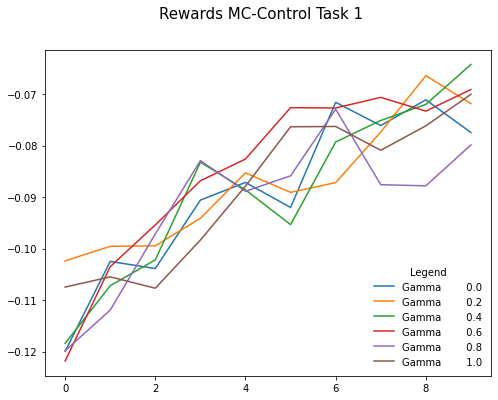

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards MC-Control Task 1', fontsize=15)
for i in range(len(rewards_cnt)):
    #print(i)
    ax.plot(rewards_cnt[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

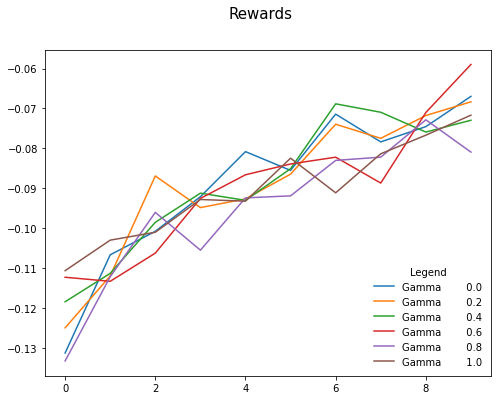

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards_cnt)):
    #print(i)
    ax.plot(rewards_cnt[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

#Q-learning (Task 1.2-3)

In [14]:
def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))
        

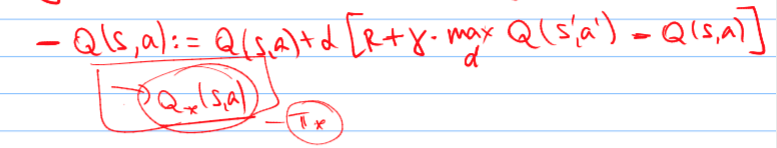

In [15]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, R, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    Q_current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    if next_state is not None:
        maxQ_next = np.max(Q[next_state])
    else: 
        maxQ_next = 0  # value of next state 

    Qsa_new = Q_current + alpha * (R + gamma * maxQ_next - Q_current) # get updated value 
    return Qsa_new

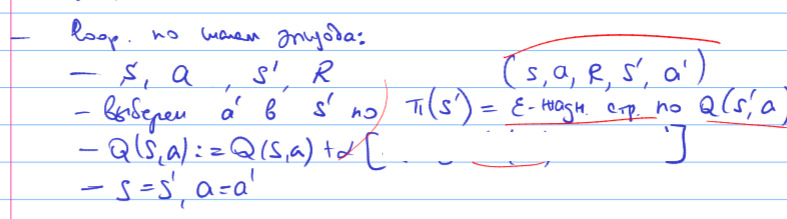

In [16]:
def generate_episode_Q_sarsamax(bj_env, Q, epsilon, nA, alpha, gamma):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    score = 0                                              # initialize score
    state = bj_env.reset()
    while True:
        # eps greedy
        if random.random() > epsilon:
            action = np.argmax(Q[state])
        else:
            action = random.choice(np.arange(env.action_space.n))

        next_state, reward, done, info = bj_env.step(action)  # take action A, observe R, S'
        episode.append((state, action, reward))
        
        # Q update
        score += reward                                       # add reward to agent's score
        Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                             state, action, reward, next_state)        
        state = next_state                                 # S <- S'
        if done: # note: no A <- A'
            break
    return episode, Q 

In [17]:
def generate_episode_Q_sarsamax_test(bj_env, Q, nA, alpha, gamma):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    score = 0
    state = bj_env.reset()
    while True:
        action = np.argmax(Q[state])

        next_state, reward, done, info = bj_env.step(action)  # take action A, observe R, S'
        episode.append((state, action, reward))
      
        score += reward                                       # add reward to agent's score
        Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                             state, action, reward, next_state)        
        state = next_state          

        if done: 
            break
    return episode

In [18]:
def average_reward_q(env, Q, nA, alpha, gamma, n_episodes=100_000):

    rewards = 0
    epsilon = 0
    for _ in range(n_episodes):
        rewards += generate_episode_Q_sarsamax_test(env, Q, nA, alpha, gamma)[-1][-1]
    return rewards / n_episodes

In [19]:
def q_learning(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    rewards_list = []
    rew = 0
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = max(1.0 / i_episode ,epsmin)                                 # set value of epsilon
        
        # для каждого шага в эпизоде
        episode, Q = generate_episode_Q_sarsamax(env, Q, eps, nA, alpha, gamma)
        
      
        rew += episode[-1][-1]
        if i_episode % 10_000 == 0:
            rewards_list.append(average_reward_q(env, Q, nA, alpha, gamma))
    
    print(rew / num_episodes)

    return Q, rewards_list

In [ ]:
Q, rewards = q_learning(env, 100_000, 0.015)

Episode 100000/100000-0.18148


In [ ]:
from tqdm.notebook import  tqdm

rewards_sarsa = []

for j in tqdm(range(0, 11, 2)):
    Q, rewards = q_learning(env, 100_000, 0.015, gamma= j / 10)
    rewards_sarsa.append(rewards)

Episode 100000/100000-0.06341
Episode 100000/100000-0.06732
Episode 100000/100000-0.0839
Episode 100000/100000-0.11565
Episode 100000/100000-0.14951
Episode 100000/100000-0.17716



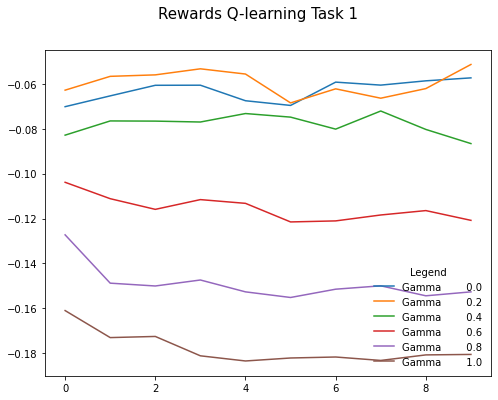

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards Q-learning Task 1 ', fontsize=15)
for i in range(len(rewards_sarsa)):
    #print(i)
    ax.plot(rewards_sarsa[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()